# 1.Import Data
## 1.1.Import Prediction

In [21]:
# import libraries
import pickle
import tensorflow as tf
import pandas as pd
import re
from tqdm import tqdm
import numpy as np

In [42]:
path_dict0={
    "LogisticRegression_baseline_preds":"baseline_logisticregression_preds",
    "Kernel_SVM_baseline_preds":"baseline_kernel_svm_preds",
    #"SVM_baseline_preds":"baseline_svm_preds",
    "LogisticRegression_preds":"LogisticRegression_preds",
    "CNN_preds":"CNN_preds",
    "Kernel_SVM_preds":"Kernel_SVM_preds",
    "SVM_preds":"SVM_preds",
    "LSTM_preds":"LSTM_preds",
    "GRU_preds":"GRU_preds"
}

path_dict1={
    "LogisticRegression_baseline_scores":"baseline_logisticregression_scores",
    "Kernel_SVM_baseline_scores":"baseline_kernel_svm_scores",
    #"SVM_baseline_scores":"baseline_svm_scores",
    "LogisticRegression_scores":"LogisticRegression_scores",
    "CNN_scores":"CNN_scores",
    "Kernel_SVM_scores":"Kernel_SVM_scores",
    "SVM_scores":"SVM_scores",
    "LSTM_scores":"LSTM_scores",
    "GRU_scores":"GRU_scores"
}

In [43]:
def open_pkl(parent_path,file_name):
    all_data=dict()
    for each_key in file_name.keys():
        name = file_name[each_key]
        pickle_file = open(parent_path+name+".pkl",mode="rb")
        data = pickle.load(pickle_file)
        pickle_file.close()
        all_data[each_key]=data
    return all_data

In [44]:
parent_path = "Prediction\\"
all_preds=open_pkl(parent_path,path_dict0)
all_scores=open_pkl(parent_path,path_dict1)

In [47]:
all_scores["LogisticRegression_baseline_scores"]

{'test_baseline': array([[  5.87041842,  -9.49915122,   3.05101782,   0.57771498],
        [  4.30353789,  -2.35381597,   0.1899078 ,  -2.13962971],
        [  1.02289807,  -2.6612374 ,  -1.77357499,   3.41191432],
        ...,
        [  5.7374296 , -11.82440348,   4.93081824,   1.15615563],
        [115.35314217, -47.86533564, -38.41235697, -29.07544955],
        [  2.59962972,  -3.17352458,  -1.13751327,   1.71140812]])}

## 1.2.Import y_test

In [48]:
y_name={
    "y_test":"test_y",
    "y_train":"train_y"
}

In [49]:
parent_path="DataSet\\"
y_data = open_pkl(parent_path,y_name)
y_test = y_data["y_test"]

In [50]:
# in order to plot ROC curve and calculate AUC, I need to turn y label into 1 hot representation.
# transfer y label from {class:[0,1,2,3]} into {class: [1,0,0,0], [0,1,0,0],[0,0,1,0],[0,0,0,1]}
emotion = {"others":0,"happy":1,"sad":2,"angry":3}
y_test1hot = tf.keras.utils.to_categorical(y_test,num_classes=4)

## 1.3.Calculation on label

In [51]:
# function for calculate the number of each class in label
def calculate_class_no(y):
    emotion = {
        0:"others",
        1:"happy",
        2:"sad",
        3:"angry"
        }
    
    cal_y=dict()
    cal_y["others"]=0
    cal_y["happy"]=0
    cal_y["sad"]=0
    cal_y["angry"]=0
    length = len(y)
    for i in range(length):
        if y[i] == 0:
            cal_y["others"] +=1
        elif y[i] == 1:
            cal_y["happy"] +=1
        elif y[i] ==2:
            cal_y["sad"] +=1
        elif y[i] ==3:
            cal_y["angry"]+=1
    
    return cal_y

In [52]:
# function for crawl the dict and caculate the number of each class on label
def calculate_class_no_all(y_data):
    y_cal = dict()
    for key in y_data.keys():
        y_cal_one = calculate_class_no(y_data[key])
        y_cal[key]=y_cal_one
    
    return y_cal

In [53]:
# function for forming dataframe
def form_df_y(y_cal):
    new_dict = dict()
    columns = ["data version","others","happy","sad","angry"]
    for each in columns:
        new_dict[each]=list()
    
    for each_key in y_cal.keys():
        new_dict["data version"].append(each_key)
        for each_data in y_cal[each_key].keys():
            new_dict[each_data].append(y_cal[each_key][each_data])
    df = pd.DataFrame.from_dict(new_dict)
    
    return df

In [54]:
y_cal = calculate_class_no_all(y_data)

In [55]:
y_cal

{'y_test': {'others': 4677, 'happy': 284, 'sad': 250, 'angry': 298},
 'y_train': {'others': 14948, 'happy': 4243, 'sad': 5463, 'angry': 5506}}

In [56]:
df_y = form_df_y(y_cal)

# save dataframe as excel for further comparison picture extraction
save_path="Prediction\\df_y"
df_y.to_excel(save_path+".xlsx",sheet_name="comparison_evaluation")

In [57]:
df_y

,data version,others,happy,sad,angry
0,y_test,4677,284,250,298
1,y_train,14948,4243,5463,5506


# 2.Evaluation on accuracy, precision, recall, F1 score

In [62]:
# function for getting accuracy, precision, recall, F1 score on each label
def calculate_eachlabel(y_test,y_pred,choose):
    emotion={
        "others":0,
        "happy":1,
        "sad":2,
        "angry":3
        }
    label_choose = emotion[choose]
    
    TP =0
    TN =0
    FP =0
    FN =0
    
    for i in range(len(y_test)):
        if y_test[i] == label_choose and y_pred[i] == label_choose:
            TP +=1
            
        elif y_test[i] == label_choose and y_pred[i] != label_choose:
            FN +=1
        
        elif y_test[i] != label_choose and y_pred[i] == label_choose:
            FP +=1
        elif y_test[i] != label_choose and y_pred[i] != label_choose:
            TN +=1
    accuracy = (TP + TN)/(TP + TN + FP + FN)
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)
    if precision == 0 and recall ==0:
        f1_score =0
    else:
        f1_score = 2*(precision*recall)/(precision + recall)
    
    return accuracy,precision,recall,f1_score

In [63]:
#from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
# print evaluation result
def get_evaluation(y_test,y_pred):
    emotion = ["others","happy","sad","angry"]
    ev = dict()
    #ev["confusion_matrix"]=confusion_matrix(y_test,y_pred)
    ev["accuracy"] = accuracy_score(y_test,y_pred)
    ev["precision_macro"]=precision_score(y_test,y_pred,average="macro")
    ev["precision_micro"]=precision_score(y_test,y_pred,average="micro")
    ev["precision_weighted"]=precision_score(y_test,y_pred,average="weighted")
    ev["recall_macro"]=recall_score(y_test,y_pred,average="macro")
    ev["recall_micro"]=recall_score(y_test,y_pred,average="micro")
    ev["recall_weighted"]=recall_score(y_test,y_pred,average="weighted")
    ev["F1_score_macro"]=f1_score(y_test,y_pred,average="macro")
    ev["F1_score_micro"]=f1_score(y_test,y_pred,average="micro")
    ev["F1_score_weighted"]=f1_score(y_test,y_pred,average="weighted")
    for each in emotion:
        accu_each = "accuracy_{0}".format(each)
        pre_each = "precision_{0}".format(each)
        re_each ="recall_{0}".format(each)
        f1_each = "F1_score_{0}".format(each)
        ev[accu_each],ev[pre_each],ev[re_each],ev[f1_each]=calculate_eachlabel(y_test,y_pred,each)

    return ev

In [64]:
def process_preds(y_test,all_preds,method):
    all_results=dict()
    for each_model in all_preds.keys():
        alldata_results=dict()
        for each_data in all_preds[each_model].keys():
            result = eval(method)(y_test,all_preds[each_model][each_data])
            alldata_results[each_data]=result
        all_results[each_model]=alldata_results
    
    return all_results

In [65]:
all_ev = process_preds(y_test,all_preds,"get_evaluation")

In [77]:
# form dataframe from evaluation dict
def form_df(all_evaluation):
    
    columns=["model","data version","accuracy","precision_macro",
             "recall_macro","F1_score_macro","precision_micro","recall_micro",
             "F1_score_micro","precision_weighted","recall_weighted",
             "F1_score_weighted"]
    
    emotion = emotion = ["others","happy","sad","angry"]
    for each in emotion:
        accu_each = "accuracy_{0}".format(each)
        pre_each = "precision_{0}".format(each)
        re_each ="recall_{0}".format(each)
        f1_each = "F1_score_{0}".format(each)
        columns.append(accu_each)
        columns.append(pre_each)
        columns.append(re_each)
        columns.append(f1_each)
    
    new_dict = dict()
    
    for each_column in columns:
        new_dict[each_column]=list()
    
    for each_model in all_evaluation.keys():
        for each_data in all_evaluation[each_model].keys():
            modelname = re.sub(r'\_baseline','',each_model)
            new_dict["model"].append(re.sub(r'\_preds','',modelname))
            new_dict["data version"].append(each_data)
            
            for each_column in all_evaluation[each_model][each_data].keys():
                new_dict[each_column].append(all_evaluation[each_model][each_data][each_column])
            
    
    df=pd.DataFrame.from_dict(new_dict)
    
    return df

In [78]:
df=form_df(all_ev)
# save dataframe as excel for further comparison picture extraction
save_path="Prediction\\df_evaluation"
df.to_excel(save_path+".xlsx",sheet_name="comparison_evaluation")

In [79]:
df

,model,data version,accuracy,precision_macro,recall_macro,F1_score_macro,precision_micro,recall_micro,F1_score_micro,precision_weighted,...,recall_happy,F1_score_happy,accuracy_sad,precision_sad,recall_sad,F1_score_sad,accuracy_angry,precision_angry,recall_angry,F1_score_angry
0,LogisticRegression,test_baseline,0.730804,0.431355,0.581293,0.473911,0.730804,0.730804,0.730804,0.826814,...,0.415493,0.274419,0.911055,0.260956,0.524,0.348404,0.912507,0.333333,0.617450,0.432941
1,Kernel_SVM,test_baseline,0.838446,0.261155,0.251737,0.237499,0.838446,0.838446,0.838446,0.731861,...,0.010563,0.018349,0.952078,0.000000,0.000,0.000000,0.942639,0.125000,0.010067,0.018634
2,LogisticRegression,test0,0.805954,0.504279,0.601540,0.541073,0.805954,0.805954,0.805954,0.839916,...,0.387324,0.364238,0.930659,0.336634,0.544,0.415902,0.931748,0.412556,0.617450,0.494624
3,LogisticRegression,test1,0.811400,0.515771,0.615444,0.554141,0.811400,0.811400,0.811400,0.844718,...,0.433099,0.400000,0.931748,0.337629,0.524,0.410658,0.933926,0.426667,0.644295,0.513369
4,LogisticRegression,test2,0.819931,0.537011,0.647657,0.579110,0.819931,0.819931,0.819931,0.853863,...,0.482394,0.447712,0.935923,0.369620,0.584,0.452713,0.933745,0.427332,0.661074,0.519104
5,LogisticRegression,test3,0.798148,0.499211,0.613248,0.541259,0.798148,0.798148,0.798148,0.839788,...,0.415493,0.368750,0.928662,0.329356,0.552,0.412556,0.930840,0.410753,0.640940,0.500655
6,LogisticRegression,test4,0.799964,0.499223,0.607400,0.540246,0.799964,0.799964,0.799964,0.839503,...,0.422535,0.364742,0.930659,0.333333,0.528,0.408669,0.932474,0.417778,0.630872,0.502674
7,LogisticRegression,test5,0.806135,0.516439,0.638460,0.561606,0.806135,0.806135,0.806135,0.847932,...,0.485915,0.425926,0.932111,0.352381,0.592,0.441791,0.929570,0.403017,0.627517,0.490814
8,CNN,test2,0.866037,0.634014,0.815111,0.702945,0.866037,0.866037,0.866037,0.900604,...,0.707746,0.580925,0.961154,0.546392,0.848,0.664577,0.950808,0.529032,0.825503,0.644823
9,CNN,test5,0.871665,0.647829,0.799548,0.707455,0.871665,0.871665,0.871665,0.900029,...,0.704225,0.613497,0.965148,0.585799,0.792,0.673469,0.945544,0.497942,0.812081,0.617347


# 3.Evaluation with ROC curve, AUC on same model

In [90]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

In [91]:
def compute_roc_auc(y_test1hot, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_class = 4
    
    # compute roc curve and auc based on each label
    for i in range(n_class):
        fpr[i],tpr[i],_ = roc_curve(y_test1hot[:,i],y_score[:,i])
        roc_auc[i] = auc(fpr[i],tpr[i])
    
    # compute roc curve and auc based on average type = "micro"
    fpr["micro"],tpr["micro"],_=roc_curve(y_test1hot.ravel(),y_score.ravel())
    roc_auc["micro"]=auc(fpr["micro"],tpr["micro"])
    
    # compute roc curve and auc based on average type = "macro"
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_class)]))
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_class):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
    # Finally average it and compute AUC
    mean_tpr = mean_tpr/n_class
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"],tpr["macro"])
    
    return fpr, tpr, roc_auc

In [92]:
def compute_roc_auc_singlemodel(y_test1hot, y_scores):
    fprs=dict()
    tprs=dict()
    roc_aucs=dict()
    for key in tqdm(y_scores.keys()):
        fprs[key],tprs[key],roc_aucs[key]=compute_roc_auc(y_test1hot,y_scores[key])
    
    return fprs,tprs,roc_aucs

In [93]:
def compute_roc_auc_allmodel(y_test1hot, y_all_scores):
    all_fprs=dict()
    all_tprs=dict()
    all_roc_aucs=dict()
    for each_model in y_all_scores.keys():
        fprs,tprs,roc_aucs=compute_roc_auc_singlemodel(y_test1hot, y_all_scores[each_model])
        all_fprs[each_model]=fprs
        all_tprs[each_model]=tprs
        all_roc_aucs[each_model]=roc_aucs
        
    return all_fprs,all_tprs,all_roc_aucs

In [94]:
# compute fpr, tpr, roc_auc on each data under each model
all_fprs,all_tprs,all_roc_aucs = compute_roc_auc_allmodel(y_test1hot, all_scores)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 111.42it/s]


In [95]:
all_fprs["LogisticRegression_baseline_scores"]["test_baseline"]

{0: array([0.        , 0.        , 0.        , ..., 0.99879808, 1.        ,
        1.        ]),
 1: array([0.00000000e+00, 0.00000000e+00, 1.91387560e-04, 1.91387560e-04,
        7.65550239e-04, 7.65550239e-04, 9.56937799e-04, 9.56937799e-04,
        3.25358852e-03, 3.25358852e-03, 5.74162679e-03, 5.74162679e-03,
        6.88995215e-03, 6.88995215e-03, 1.30143541e-02, 1.30143541e-02,
        1.49282297e-02, 1.49282297e-02, 1.64593301e-02, 1.64593301e-02,
        2.20095694e-02, 2.20095694e-02, 2.33492823e-02, 2.33492823e-02,
        2.54545455e-02, 2.54545455e-02, 2.56459330e-02, 2.56459330e-02,
        3.06220096e-02, 3.06220096e-02, 3.34928230e-02, 3.34928230e-02,
        3.55980861e-02, 3.55980861e-02, 3.57894737e-02, 3.57894737e-02,
        3.63636364e-02, 3.63636364e-02, 3.75119617e-02, 3.75119617e-02,
        3.86602871e-02, 3.86602871e-02, 4.05741627e-02, 4.05741627e-02,
        4.44019139e-02, 4.44019139e-02, 4.59330144e-02, 4.59330144e-02,
        4.82296651e-02, 4.82296651e

In [117]:
def draw_pic(fpr_range,tpr_range,roc_auc,data_version,choose,color):
    try:
        emotion_no={
                0:"others",
                1:"happy",
                2:"sad",
                3:"angry"
         }
        if choose != "micro" and choose !="macro":
            label_name = emotion_no[choose]
        else:
            label_name = choose

        plt.plot(fpr_range[choose],tpr_range[choose],color=color,lw=2,
                 label="{0} ROC (AUC: {1:0.2f}) on data {2}".format(label_name,roc_auc[choose],data_version))
    except KeyError:
        pass

In [130]:
def draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type="both_embedding",choose="micro"):
    modelname_key = modelname +"_scores"
    fprs=all_fprs[modelname_key]
    tprs=all_tprs[modelname_key]
    roc_aucs=all_roc_aucs[modelname_key]
    
    # here I add baseline model under the same model as comparison
    if modelname == "SVM" or modelname == "Kernel_SVM" or modelname =="LogisticRegression":
        try:
            baselinename = modelname +"_baseline_scores"
            fprs["test_baseline"]=all_fprs[baselinename]["test_baseline"]
            tprs["test_baseline"]=all_tprs[baselinename]["test_baseline"]
            roc_aucs["test_baseline"]=all_roc_aucs[baselinename]["test_baseline"]
        except KeyError:
            pass
    
    
    emotion = {"others":0,"happy":1,"sad":2,"angry":3}
    
    # set colors choice
    colors = ["r","navy", "g","cornflowerblue","y","magenta","c"]
    
    # set the content of data version
    word2vec_list=["test0","test1","test2"]
    glove_list=["test3","test4","test5"]
    
    if modelname == "CNN" or modelname == "LSTM" or modelname == "GRU":
        word2vec_list=["test2"]
        glove_list=["test5"]
        
    both_list=list(set(word2vec_list+glove_list))+["test_baseline"]
    label_name = choose
    
    # set the label_name, i.e. choose to its number type if it's happy, sad, angry, others.
    if choose !="micro" and choose !="macro":
        choose = emotion[choose]
    
    
    
    
    
    plt.figure()
    
    # draw the line based on data resource type
    if data_type == "both_embedding":
        for pos in range(len(both_list)):
            try:
                data_version = both_list[pos]
                color = colors[pos]
                draw_pic(fprs[data_version],tprs[data_version],
                         roc_aucs[data_version],data_version,choose,color)
            except KeyError:
                continue
    elif data_type == "word2vec":
        for pos in range(len(word2vec_list)):
            data_version = both_list[pos]
            color = colors[pos]
            draw_pic(fprs[data_version],tprs[data_version],
                     roc_aucs[data_version],data_version,choose,color)
    elif data_type == "glove":
        for pos in range(len(glove_list)):
            data_version = both_list[pos]
            color = colors[pos]
            draw_pic(fprs[data_version],tprs[data_version],
                     roc_aucs[data_version],data_version,choose,color)
    
    
    
    plt.plot([0,1],[0,1],linestyle="--",color='k',lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{0} ROC Curve by model {1}'.format(label_name,modelname))
    
    plt.legend(loc="lower right")
    plt.savefig("Pictures\\{a}\\Comparison\\{b} ROC Curve by model {c} on data {d}.png".format(a=modelname,b=label_name,c=modelname,d=data_type))
    plt.show()

## 3.1. Logistic Regression

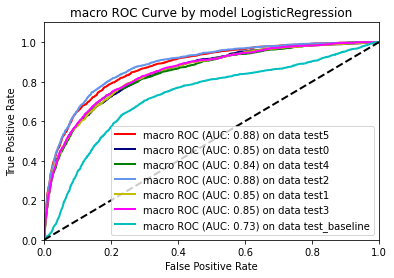

In [131]:
modelname="LogisticRegression"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

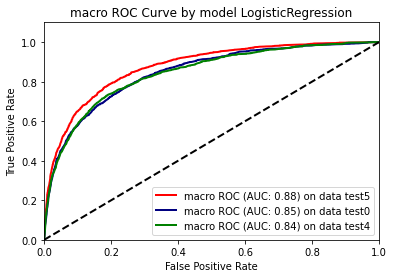

In [132]:
modelname="LogisticRegression"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

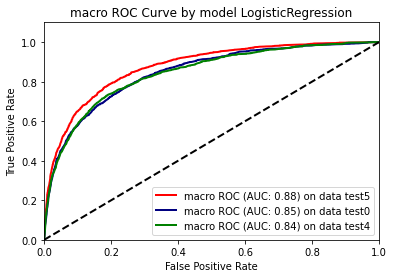

In [133]:
modelname="LogisticRegression"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

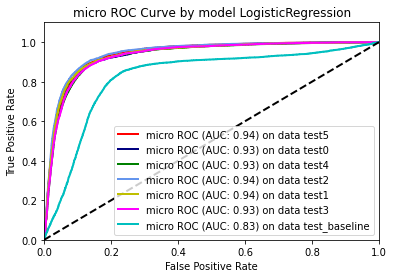

In [134]:
modelname="LogisticRegression"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

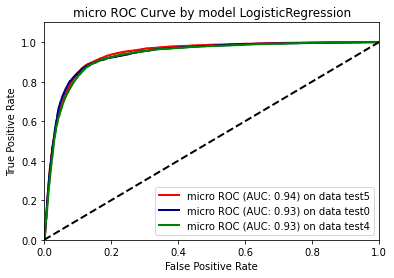

In [135]:
modelname="LogisticRegression"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

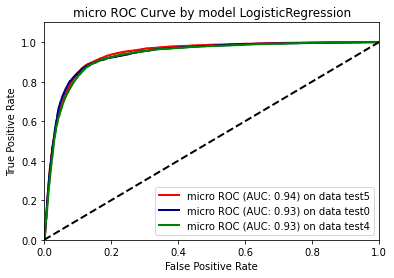

In [136]:
modelname="LogisticRegression"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

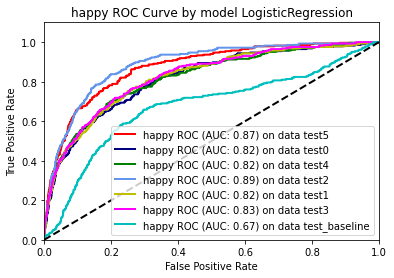

In [137]:
modelname="LogisticRegression"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

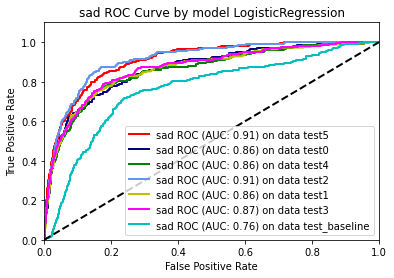

In [138]:
modelname="LogisticRegression"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

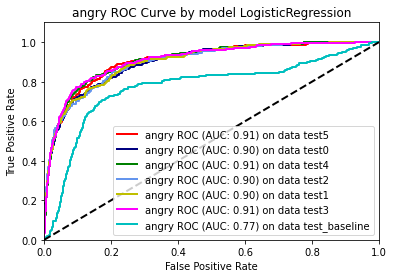

In [139]:
modelname="LogisticRegression"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.2. SVM

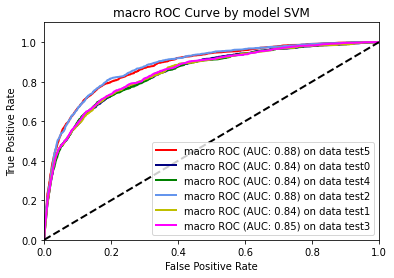

In [140]:
modelname="SVM"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

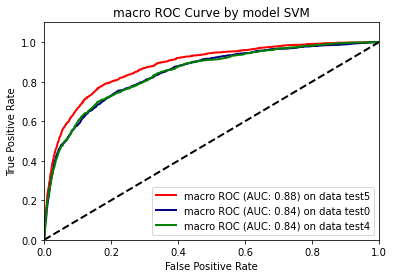

In [141]:
modelname="SVM"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

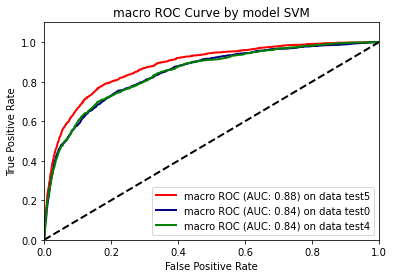

In [142]:
modelname="SVM"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

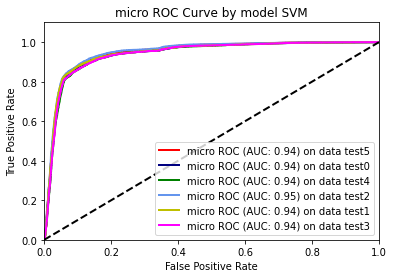

In [143]:
modelname="SVM"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

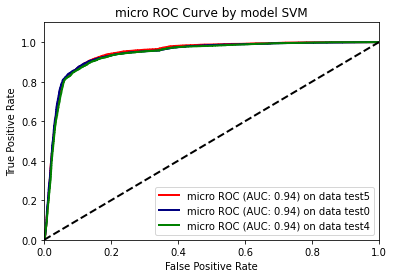

In [144]:
modelname="SVM"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

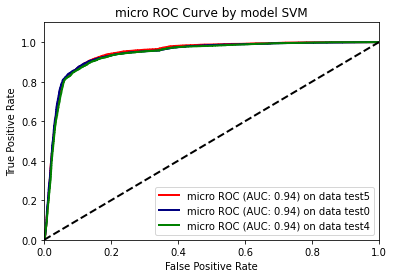

In [145]:
modelname="SVM"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

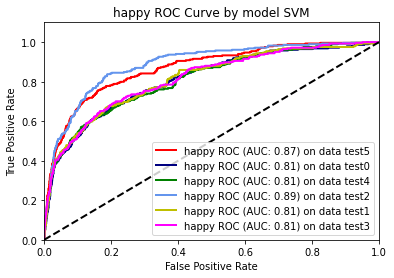

In [146]:
modelname="SVM"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

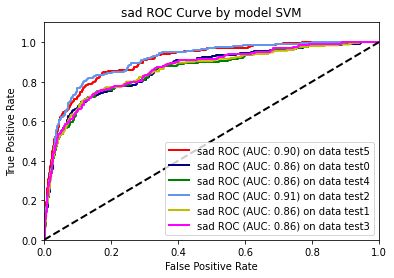

In [147]:
modelname="SVM"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

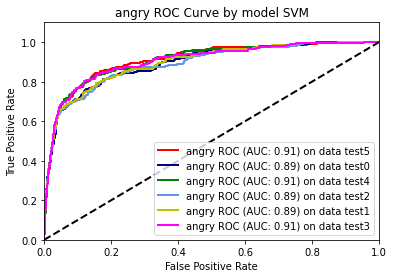

In [148]:
modelname="SVM"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

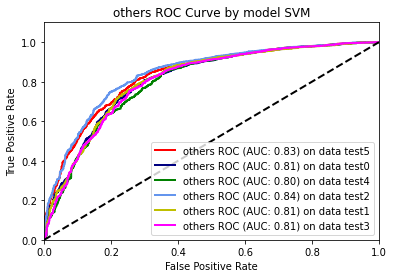

In [149]:
modelname="SVM"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.2.Kernel SVM

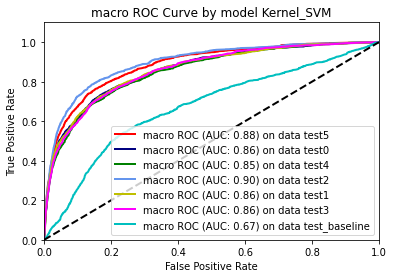

In [150]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

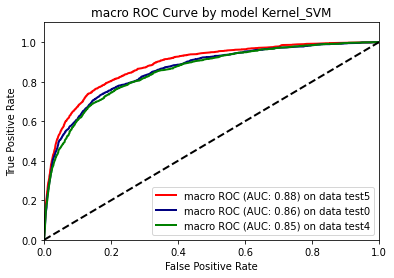

In [151]:
modelname="Kernel_SVM"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

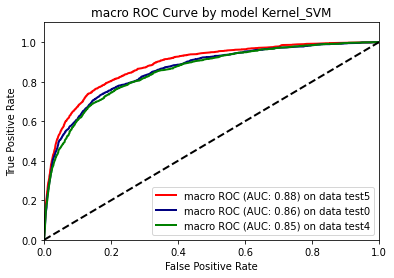

In [152]:
modelname="Kernel_SVM"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

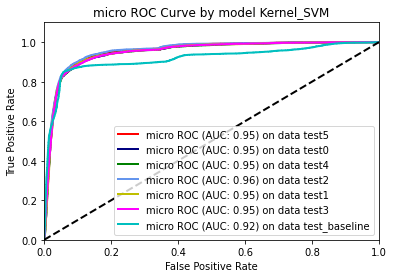

In [153]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

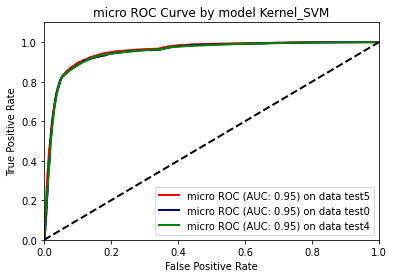

In [154]:
modelname="Kernel_SVM"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

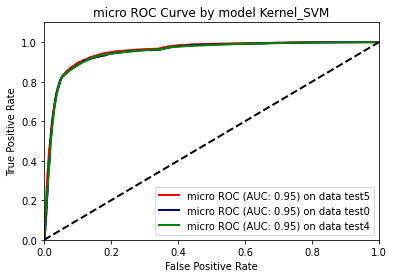

In [155]:
modelname="Kernel_SVM"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

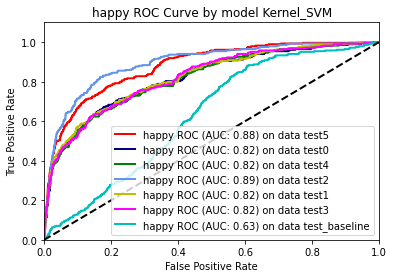

In [156]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

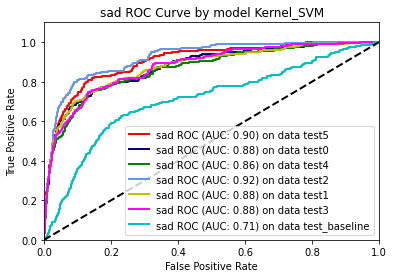

In [157]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

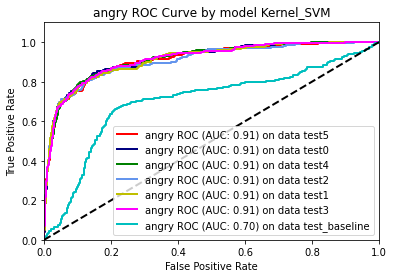

In [158]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

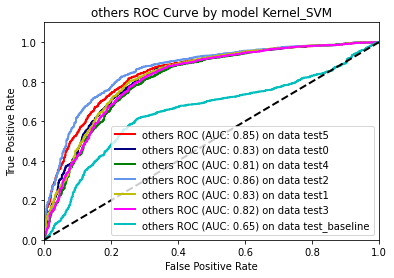

In [159]:
modelname="Kernel_SVM"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.3.CNN

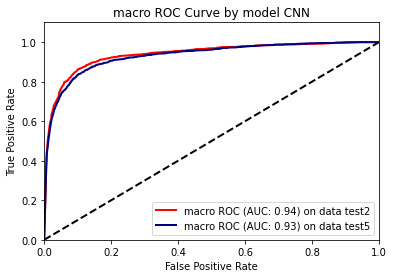

In [160]:
modelname="CNN"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

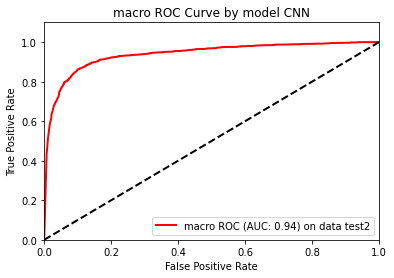

In [161]:
modelname="CNN"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

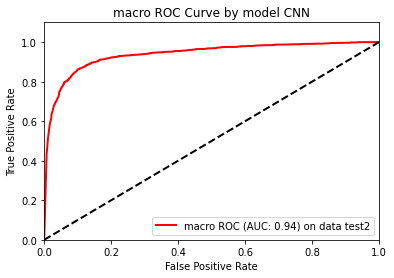

In [162]:
modelname="CNN"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

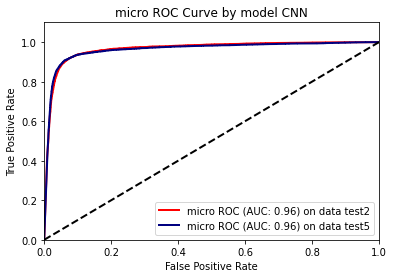

In [163]:
modelname="CNN"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

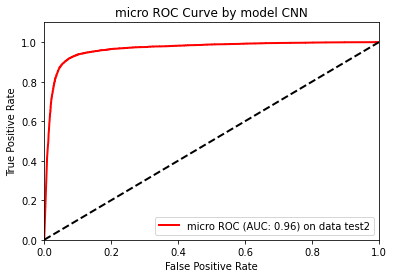

In [164]:
modelname="CNN"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

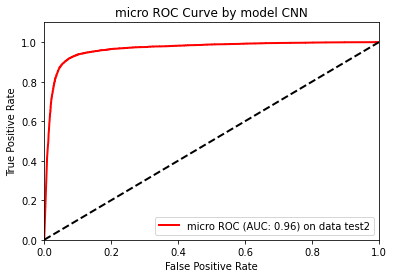

In [165]:
modelname="CNN"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

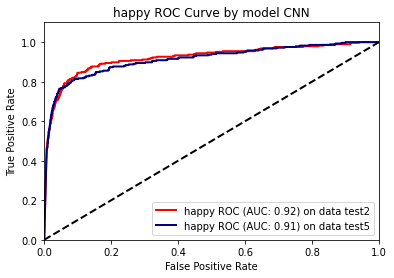

In [166]:
modelname="CNN"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

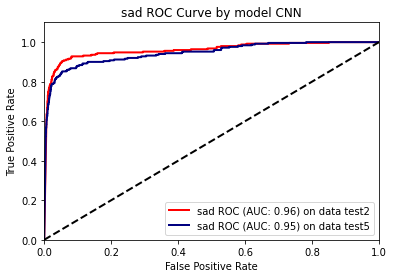

In [167]:
modelname="CNN"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

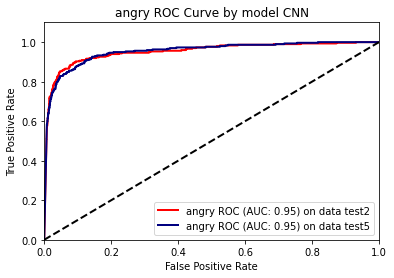

In [168]:
modelname="CNN"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

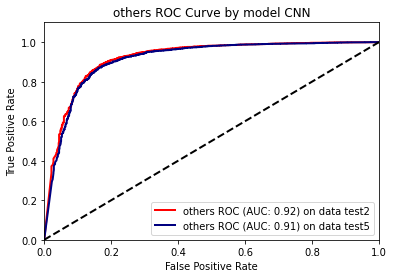

In [169]:
modelname="CNN"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.4.LSTM

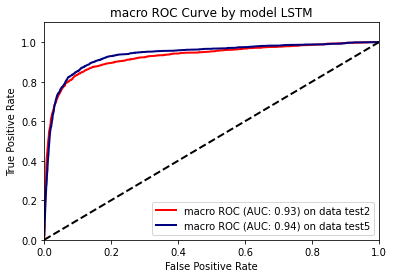

In [170]:
modelname="LSTM"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

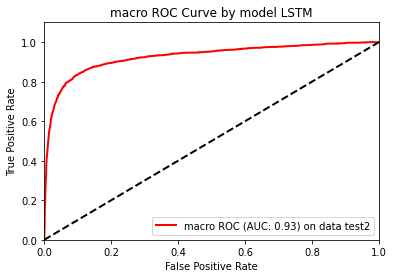

In [171]:
modelname="LSTM"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

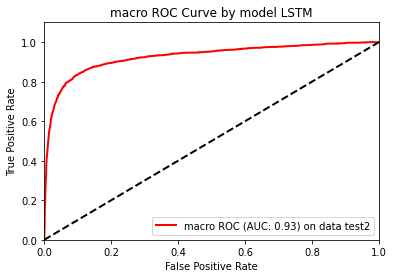

In [172]:
modelname="LSTM"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

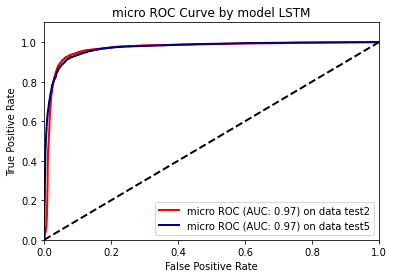

In [173]:
modelname="LSTM"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

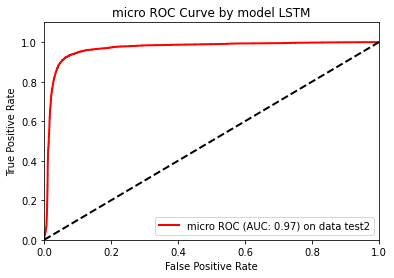

In [174]:
modelname="LSTM"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

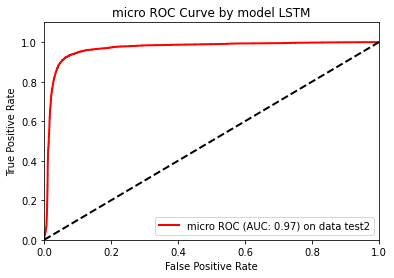

In [175]:
modelname="LSTM"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

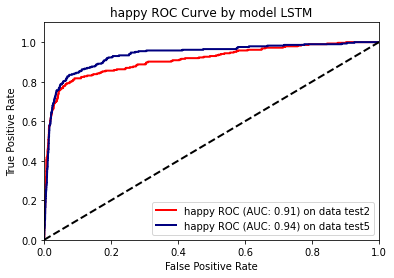

In [176]:
modelname="LSTM"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

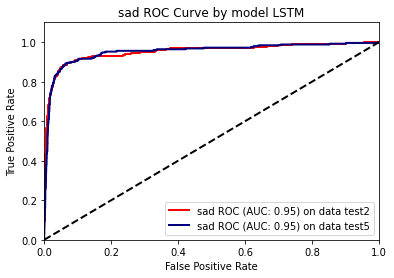

In [177]:
modelname="LSTM"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

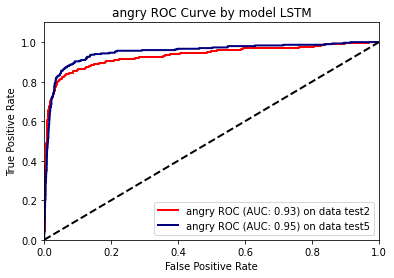

In [178]:
modelname="LSTM"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

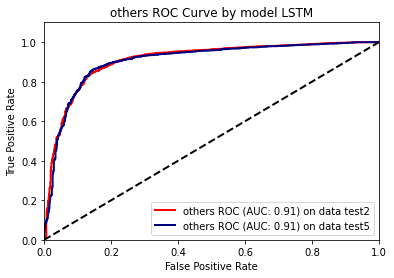

In [179]:
modelname="LSTM"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

## 3.5.GRU

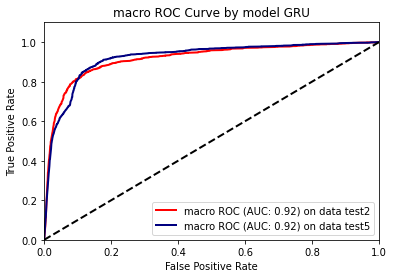

In [180]:
modelname="GRU"
data_type="both_embedding"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

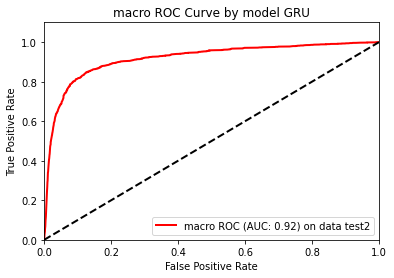

In [181]:
modelname="GRU"
data_type="word2vec"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

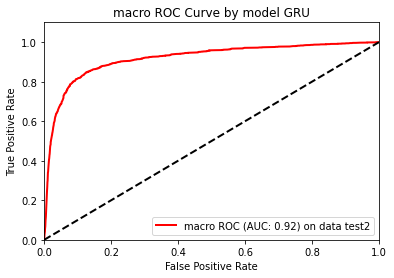

In [182]:
modelname="GRU"
data_type="glove"
choose = "macro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

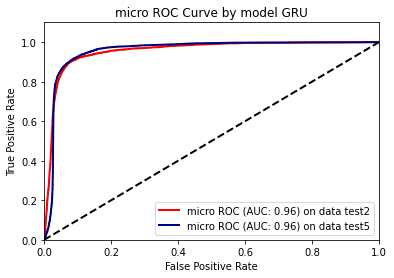

In [183]:
modelname="GRU"
data_type="both_embedding"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

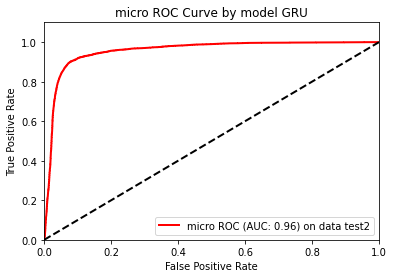

In [184]:
modelname="GRU"
data_type="word2vec"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

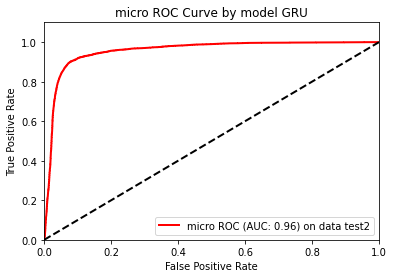

In [185]:
modelname="GRU"
data_type="glove"
choose = "micro"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

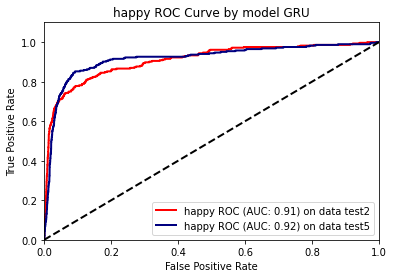

In [186]:
modelname="GRU"
data_type="both_embedding"
choose = "happy"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

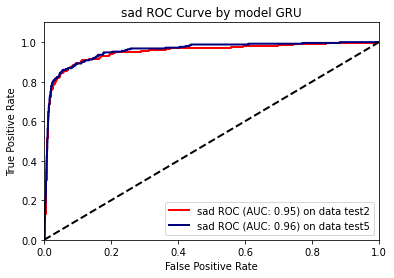

In [187]:
modelname="GRU"
data_type="both_embedding"
choose = "sad"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

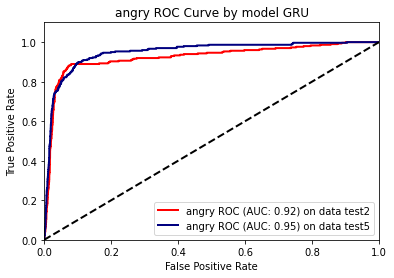

In [188]:
modelname="GRU"
data_type="both_embedding"
choose = "angry"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

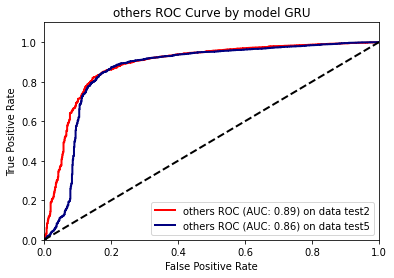

In [189]:
modelname="GRU"
data_type="both_embedding"
choose = "others"
draw_comparison_sameModel(all_fprs,all_tprs,all_roc_aucs,modelname,data_type,choose)

# 4.Evaluation with ROC, AUC on different model

In [190]:
def draw_pic_diff(fpr_range,tpr_range,roc_auc,modelname,choose,color):
    emotion_no={
            0:"others",
            1:"happy",
            2:"sad",
            3:"angry"
     }
    if choose != "micro" and choose !="macro":
        label_name = emotion_no[choose]
    else:
        label_name = choose
    
    plt.plot(fpr_range[choose],tpr_range[choose],color=color,lw=2,
             label="{0} ROC (AUC: {1:0.2f}) by {2}".format(label_name,roc_auc[choose],modelname))

In [213]:
def draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose="micro"):
    modelnames=list(all_fprs.keys())
    

    emotion = {"others":0,"happy":1,"sad":2,"angry":3}
    
    # set colors choice
    colors = ["r","navy", "g","cornflowerblue","y","magenta","c","pink","olivedrab","coral"]
    
    label_name = choose
    
    # set the label_name, i.e. choose to its number type if it's happy, sad, angry, others.
    if choose !="micro" and choose !="macro":
        choose = emotion[choose]
    
    
    plt.figure()
    
    # draw the line based on data resource type
    for pos in range(len(modelnames)):
        try:
            each_model = modelnames[pos]
            color = colors[pos]
            modelname = re.sub(r'\_scores','',each_model)
            draw_pic_diff(all_fprs[each_model][data_version],all_tprs[each_model][data_version],
                 all_roc_aucs[each_model][data_version],modelname,choose,color)
        except KeyError:
            continue
    
    
    
    plt.plot([0,1],[0,1],linestyle="--",color='k',lw=2)
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('{a} ROC Curve with all models on data {b}.png'.format(a=label_name,b=data_version))
    
    plt.legend(loc="lower right")
    plt.savefig("Pictures\\{a} ROC Curve with all models on data {b}.png".format(a=label_name,b=data_version))
    plt.show()
    

## 4.1. test2
- data based on word2vec
- data with correction of misspell and translation of shorthand words and acronyms
- data with emoji/emoticon values inside

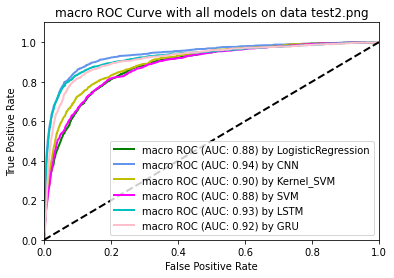

In [201]:
data_version="test2"
choose = "macro"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

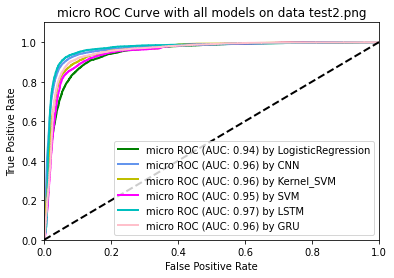

In [202]:
data_version="test2"
choose = "micro"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

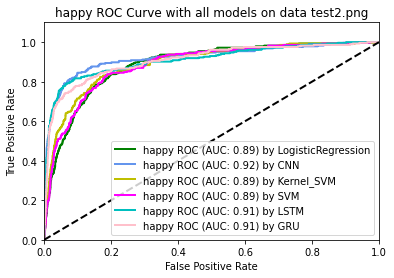

In [203]:
data_version="test2"
choose = "happy"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

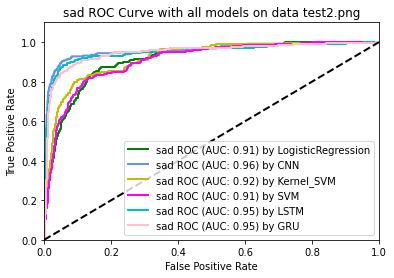

In [204]:
data_version="test2"
choose = "sad"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

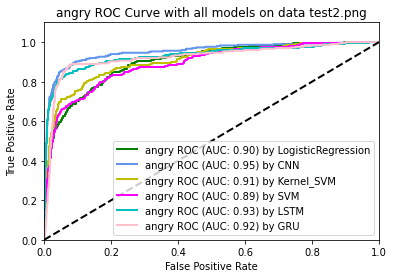

In [205]:
data_version="test2"
choose = "angry"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

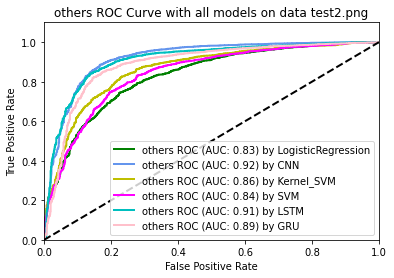

In [206]:
data_version="test2"
choose = "others"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

## 4.2. test5
- data based on glove
- data with correction of misspell and translation of shorthand words and acronyms
- data with emoji/emoticon values inside

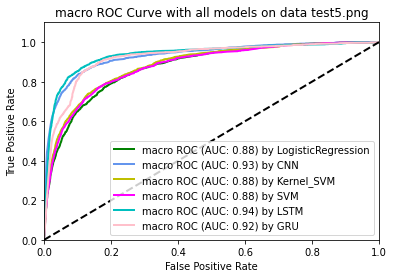

In [207]:
data_version="test5"
choose = "macro"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

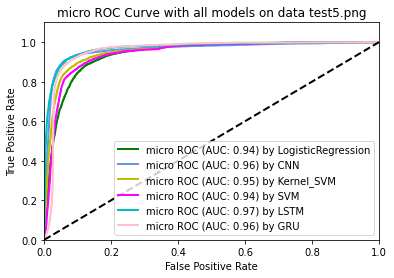

In [208]:
data_version="test5"
choose = "micro"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

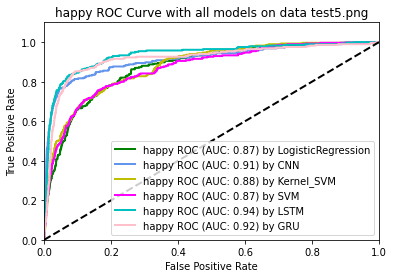

In [209]:
data_version="test5"
choose = "happy"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

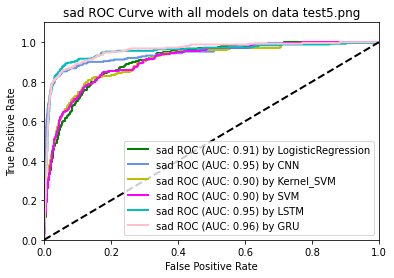

In [210]:
data_version="test5"
choose = "sad"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

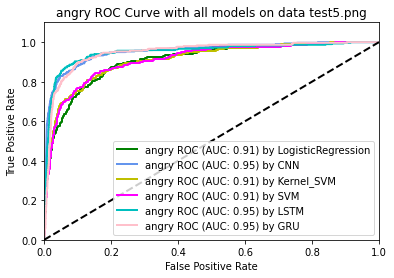

In [211]:
data_version="test5"
choose = "angry"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)

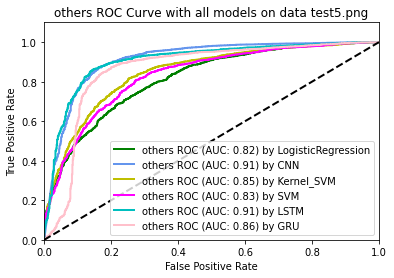

In [212]:
data_version="test5"
choose = "others"
draw_comparison_diff(all_fprs,all_tprs,all_roc_aucs,data_version,choose)